In [6]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import anndata as ad
import episcanpy.api as epi
import scanpy as sc
from scipy.sparse import csc_matrix

import os

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns



def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    
all_metrics = """Control	0.5928	0.569088	0.588754	0.714715	0.718895	0.723575	0.695935	0.701095	0.699836
BROCKMAN	0.54574	0.500141	0.499691	0.682654	0.642841	0.65918	0.67829	0.641288	0.645486
Cusanovich2018	0.943846	0.745106	0.758834	0.941653	0.851342	0.854749	0.941908	0.825158	0.813651
cisTopic	0.530953	0.529333	0.49712	0.645415	0.643513	0.629724	0.639389	0.644356	0.619491
chromVAR_kmers	0.467463	0.430748	0.417099	0.610438	0.577779	0.540338	0.555603	0.577083	0.537387
chromVAR_motifs	0.3906	0.369871	0.290375	0.520555	0.510661	0.43916	0.519439	0.512255	0.432029
chromVAR_kmers_pca	0.458582	0.492114	0.436538	0.612727	0.622779	0.568588	0.602843	0.624776	0.563519
chromVAR_motifs_pca	0.390955	0.367727	0.298085	0.524297	0.48803	0.427891	0.522027	0.489588	0.417594
GeneScoring	0.00267149	0.111998	0.103837	0.00570611	0.20693	0.179649	0.011055	0.1803	0.149194
GeneScoring_pca	0.09707	0.135782	0.106418	0.117303	0.222123	0.200712	0.113637	0.205834	0.179901
Cicero	0.00687868	0.142307	0.397534	0.0111747	0.389042	0.589552	0.0168549	0.249484	0.48291
Cicero_pca	0.448862	0.443354	0.423914	0.534053	0.566373	0.562634	0.522034	0.547409	0.50774
SnapATAC	0.804994	0.860076	0.770361	0.84069	0.874407	0.816767	0.841453	0.875022	0.816121
Scasat	0.613989	0.634201	0.590497	0.724743	0.74057	0.708525	0.715335	0.741861	0.705696
scABC	0.20426	0.448982	0.465818	0.247493	0.583171	0.568088	0.229539	0.529003	0.531906
SCRAT	0.444511	0.448028	0.457745	0.610931	0.581328	0.59356	0.596725	0.582187	0.592494
SCRAT_pca	0.469748	0.405095	0.461812	0.606473	0.585137	0.597519	0.601129	0.571914	0.591323
"""


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
%%R -o features -o cells -o mtx
df_count = readRDS('./input/bonemarrow_cov500.rds')
mtx=as.matrix(df_count)
features = df_count@Dimnames[[1]]
cells = df_count@Dimnames[[2]]

In [8]:
# format the data
mtx=csc_matrix(mtx).transpose()
cells = cells.tolist()
features = features.tolist()

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

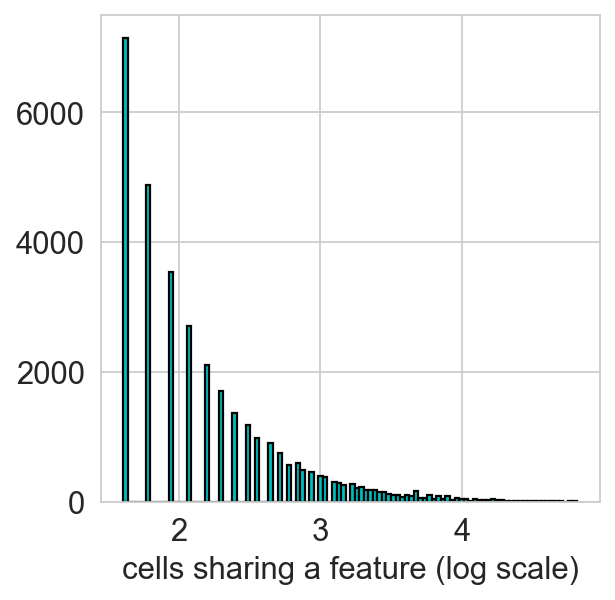

AnnData object with n_obs × n_vars = 1200 × 34239 
    obs: 'cell_type', 'n_features', 'nb_features'
    var: 'n_cells', 'commonness'


... storing 'cell_type' as categorical


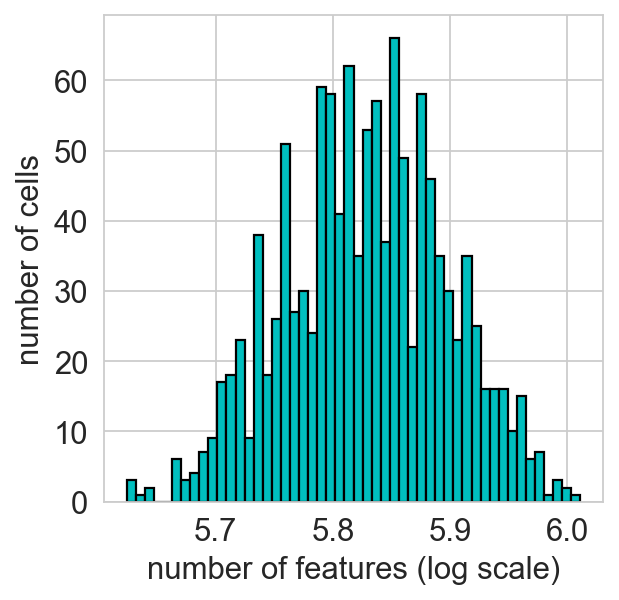

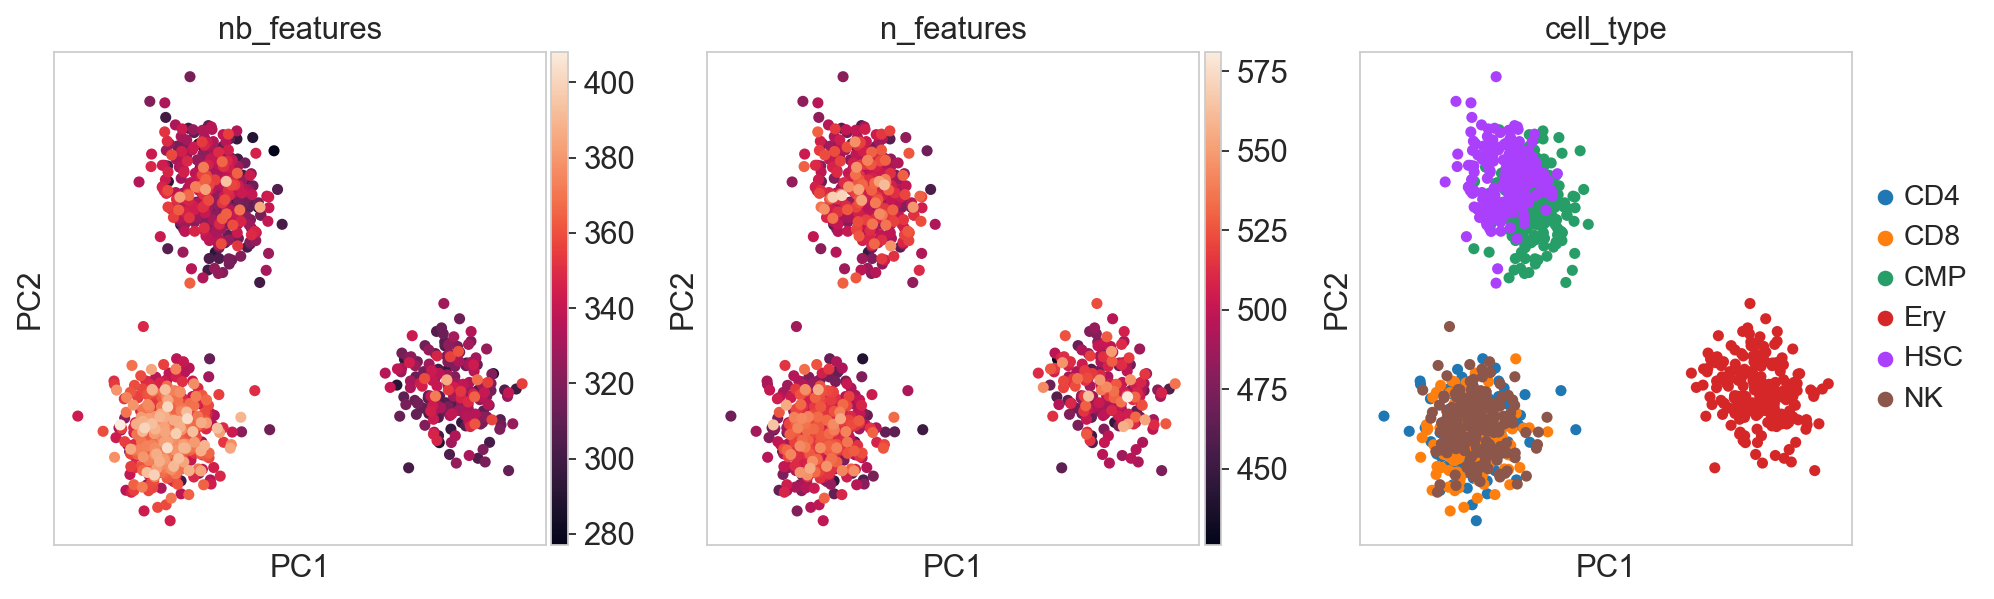

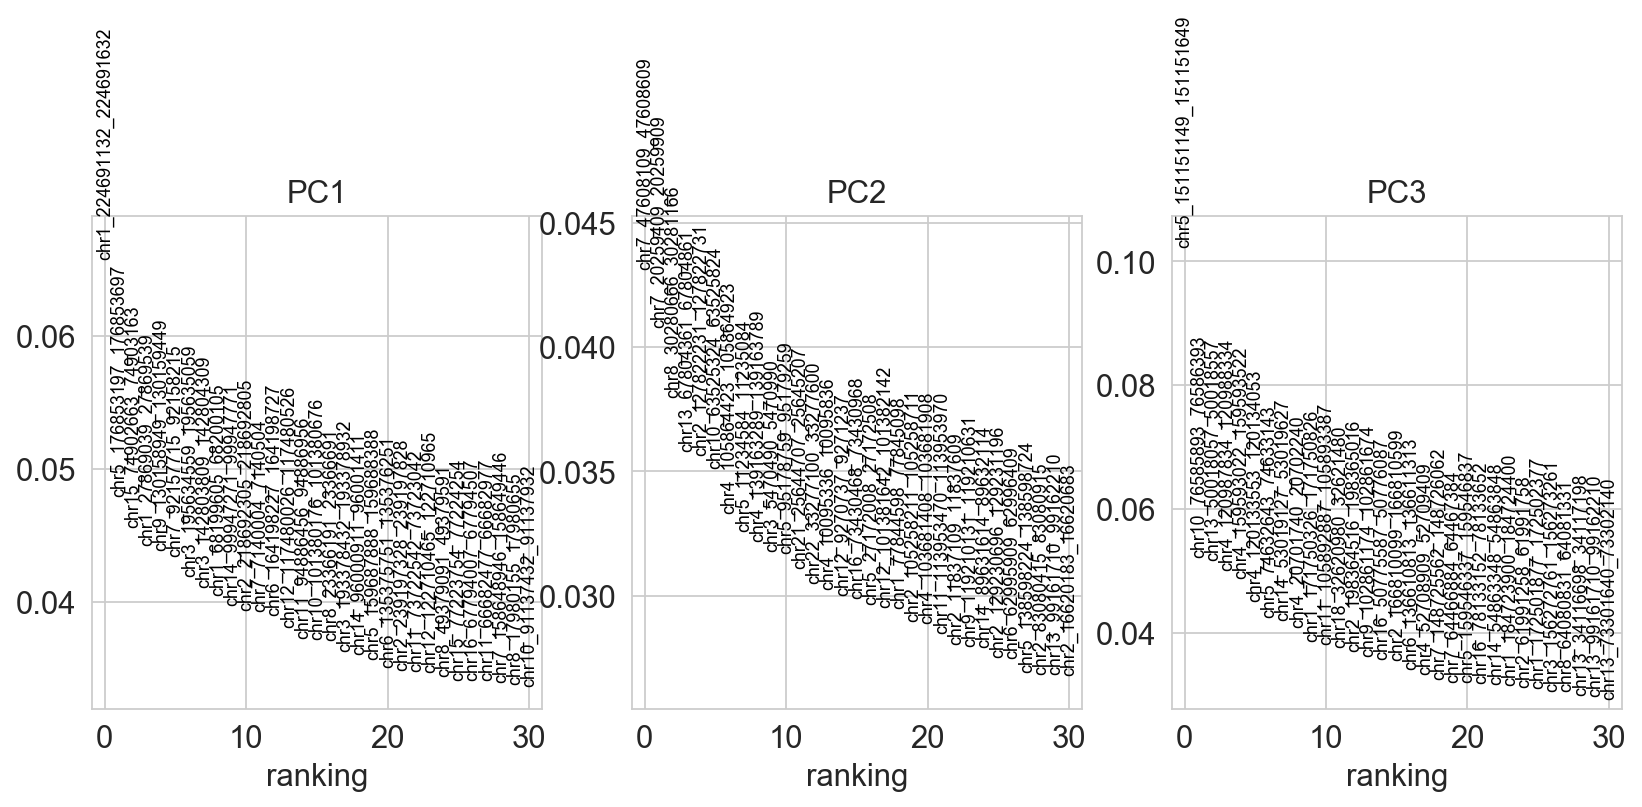

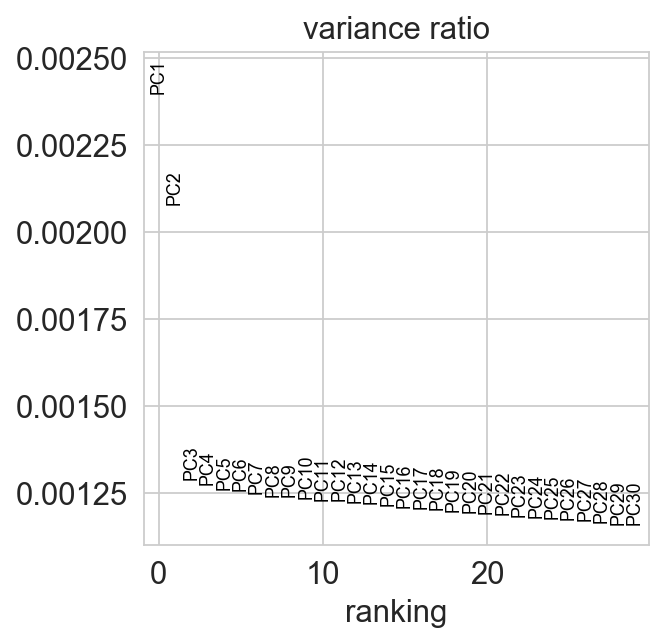

In [11]:
adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))

# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)
#print(adata)

#epi.pp.commonness_features(adata, binary=True)
#epi.pp.coverage_cells(adata, binary=True)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=5)

#epi.pp.select_var_feature(adata, nb_features=10000)

epi.pp.commonness_features(adata, binary=True, log=True)
epi.pp.coverage_cells(adata, binary=True, log=True)

sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=False,
                                      max_fraction=0.05, key_added=None, layers=None,
                                      layer_norm=None, inplace=True)

sc.pp.log1p(adata)

#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)
#adata = adata[:, adata.var['highly_variable']]
print(adata)

adatareduced = adata.copy()
epi.pp.pca(adatareduced, n_comps=30)
sc.pl.pca_overview(adatareduced, color=['nb_features', 'n_features', 'cell_type'])

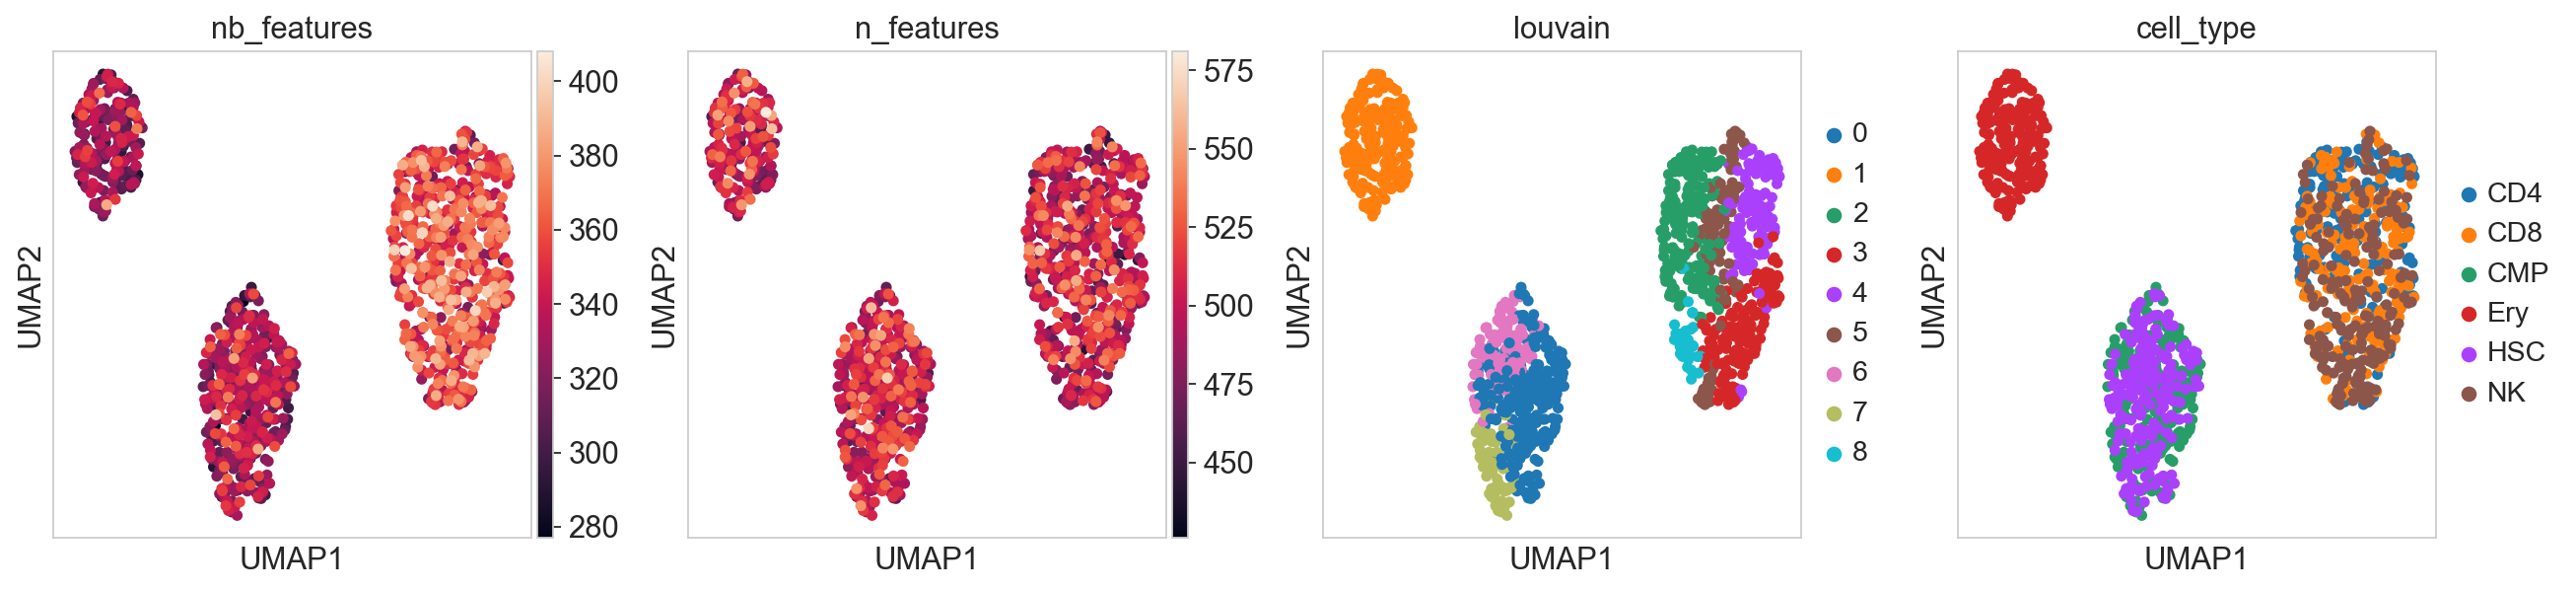

In [17]:
epi.pp.pca(adatareduced, n_comps=5)
sc.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
epi.tl.louvain(adatareduced)
#sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cel  l_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

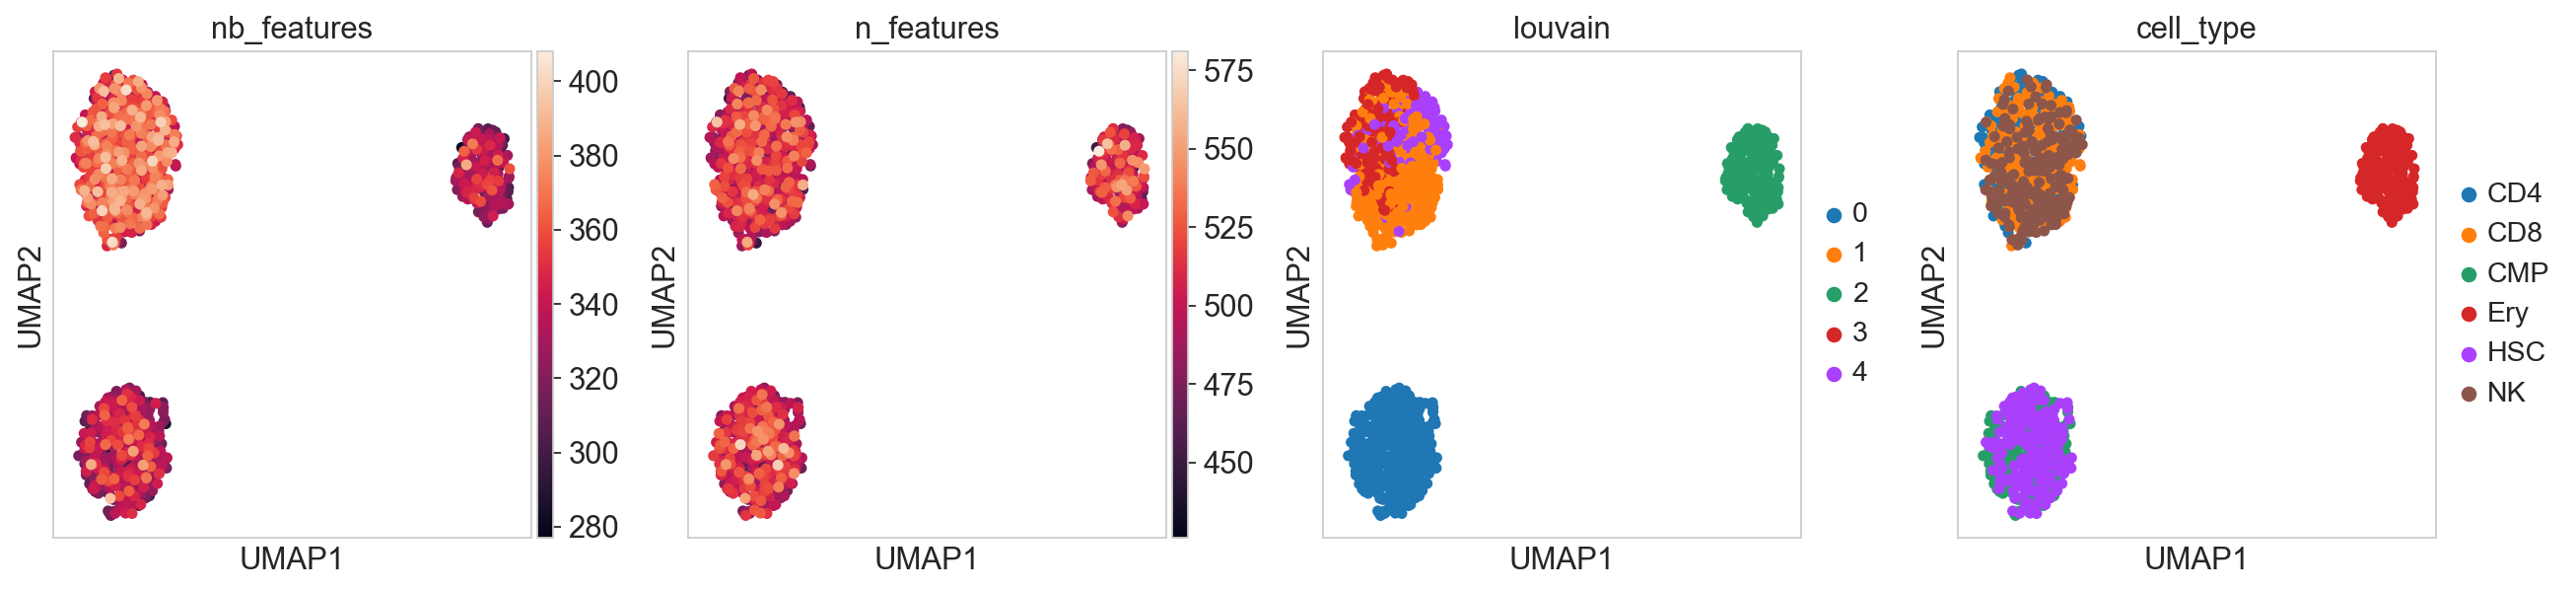

In [20]:
epi.pp.pca(adatareduced, n_comps=10)
sc.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
epi.tl.louvain(adatareduced)
#sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cel  l_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

0.47685750767972696
step 0
got 10 at resolution 1.5
step 1
got 3 at resolution 0.75
step 2
got 7 at resolution 1.125
step 3
got 4 at resolution 0.9375
step 4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


got 6 at resolution 1.03125


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

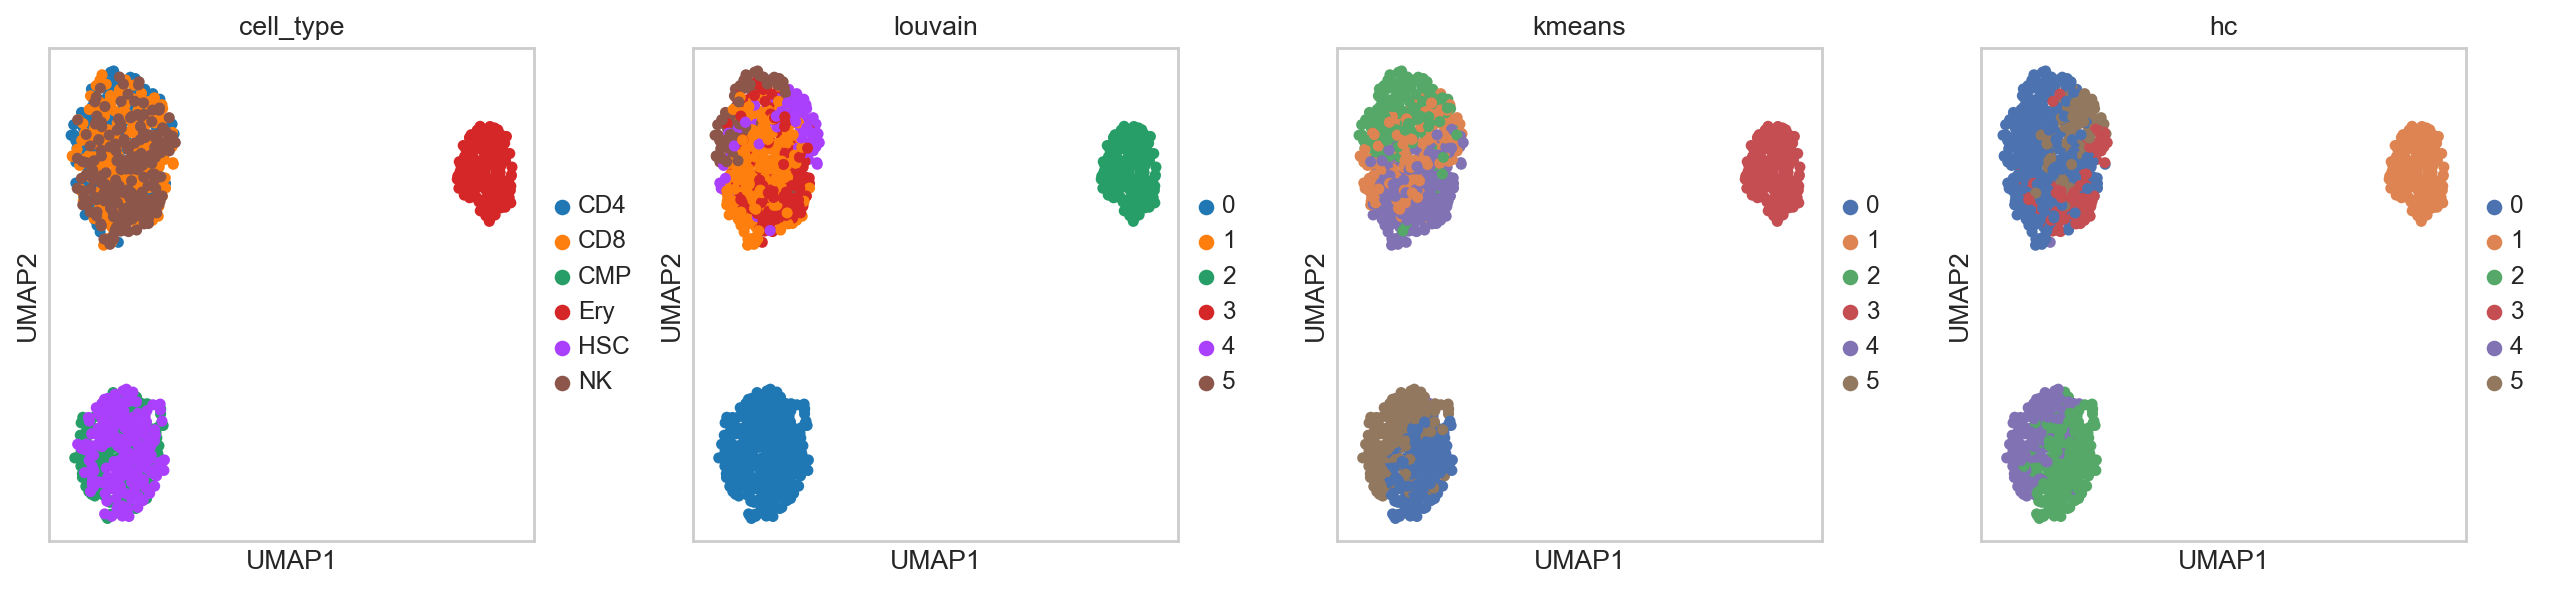

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['BROCKMAN', '0.443817', '0.384405', '0.425049', '0.591878', '0.548319', '0.603044', '0.583846', '0.536774', '0.588663']
['Cusanovich2018', '0.518985', '0.557346', '0.520973', '0.65191', '0.694411', '0.651651', '0.650078', '0.657094', '0.617172']
['cisTopic', '0.426681', '0.428198', '0.427', '0.582059', '0.578854', '0.578283', '0.57882', '0.580315', '0.580238']
['chromVAR_kmers', '0.367749', '0.348663', '0.297824', '0.451998', '0.45965', '0.35703', '0.432026', '0.461088', '0.352456']
['chromVAR_motifs', '0.101836', '0.102986', '0.0694161', '0.1653', '0.14777', '0.122929', '0.167011', '0.152132', '0.125115']
['chromVAR_kmers_pca', '0.372098', '0.374914', '0.294734', '0.465553', '0.496276', '0.387262', '0.463427', '0.498582', '0.381975']
['chromVAR_motifs_pca', '0.121054', '0.0905712', '0.0930063', '0.188937', '0.145689', '0.155174', '0.190978', '0.150077', '0.156825']
['GeneScoring', '-0.000120752', '0.00577751', '0.0138995', '0.00291468', '0.0122876', '0.0513902', '0.00851104', '0.0161

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

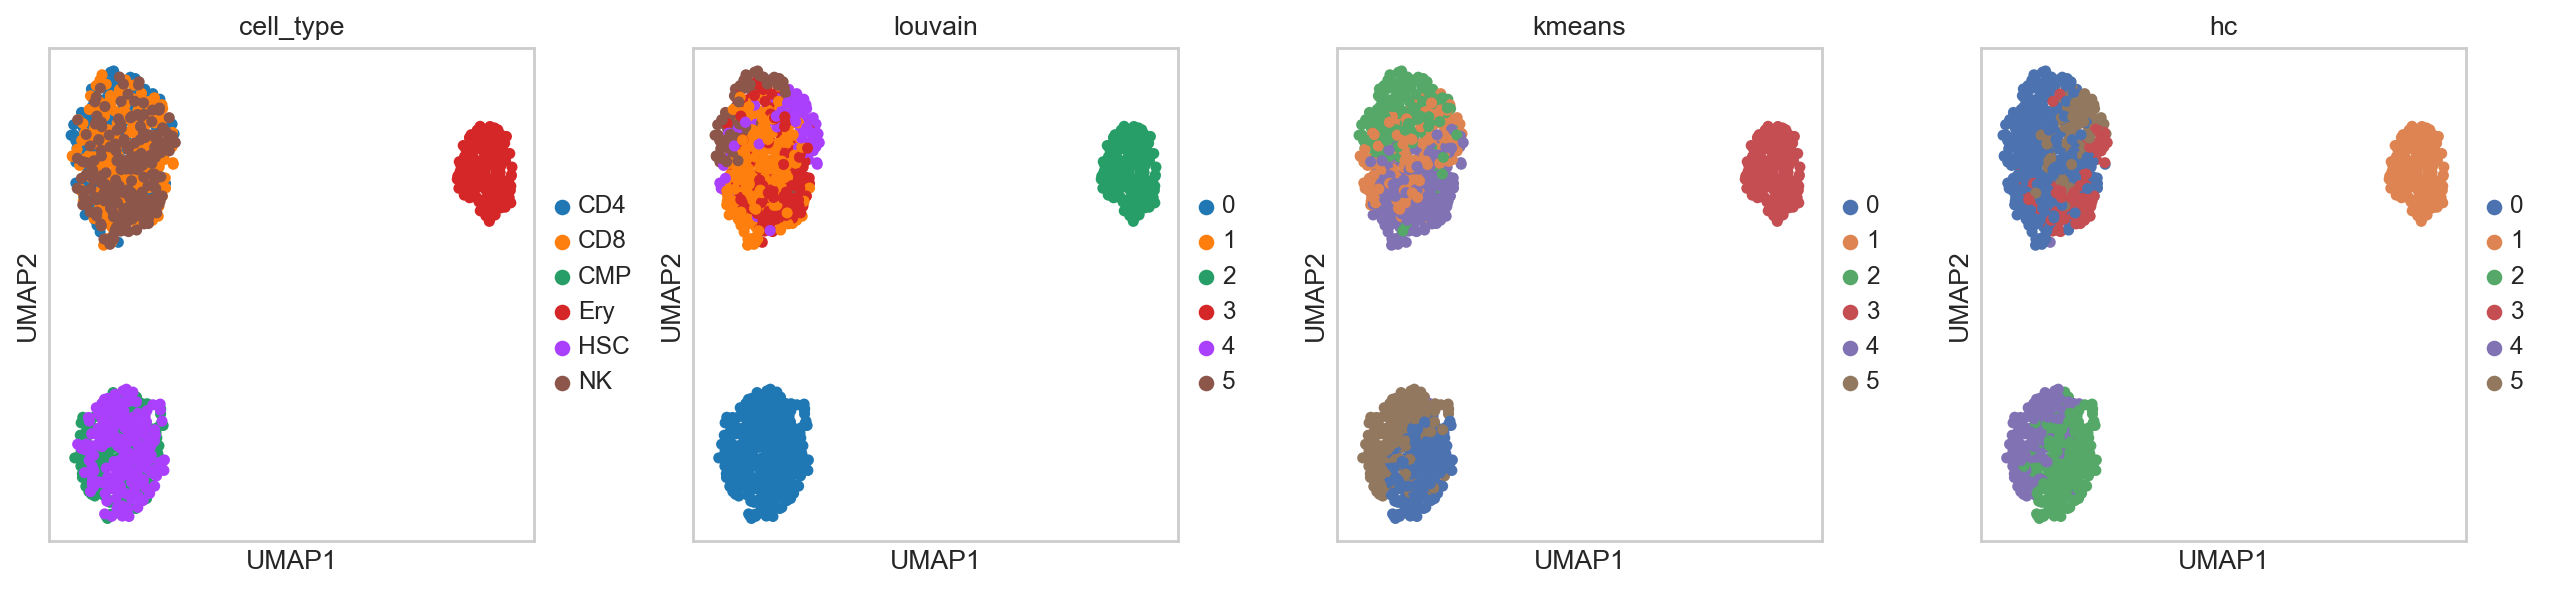

,ARI_Louvain,ARI_kmeans,ARI_HC,AMI_Louvain,AMI_kmeans,AMI_HC,Homogeneity_Louvain,Homogeneity_kmeans,Homogeneity_HC,method
epiScanpy-adata,0.470821,0.414991,0.414218,0.590342,0.570124,0.582158,0.567994,0.572473,0.567188,epiScanpy-adata
BROCKMAN,0.443817,0.384405,0.425049,0.591878,0.548319,0.603044,0.583846,0.536774,0.588663,BROCKMAN
Cusanovich2018,0.518985,0.557346,0.520973,0.651910,0.694411,0.651651,0.650078,0.657094,0.617172,Cusanovich2018
cisTopic,0.426681,0.428198,0.427000,0.582059,0.578854,0.578283,0.578820,0.580315,0.580238,cisTopic
chromVAR_kmers,0.367749,0.348663,0.297824,0.451998,0.459650,0.357030,0.432026,0.461088,0.352456,chromVAR_kmers
chromVAR_motifs,0.101836,0.102986,0.069416,0.165300,0.147770,0.122929,0.167011,0.152132,0.125115,chromVAR_motifs
chromVAR_kmers_pca,0.372098,0.374914,0.294734,0.465553,0.496276,0.387262,0.463427,0.498582,0.381975,chromVAR_kmers_pca
chromVAR_motifs_pca,0.121054,0.090571,0.093006,0.188937,0.145689,0.155174,0.190978,0.150077,0.156825,chromVAR_motifs_pca
GeneScoring,-0.000121,0.005778,0.013900,0.002915,0.012288,0.051390,0.008511,0.016199,0.044210,GeneScoring
GeneScoring_pca,0.003583,0.001876,0.001729,0.009419,0.007290,0.007843,0.013750,0.011677,0.012062,GeneScoring_pca


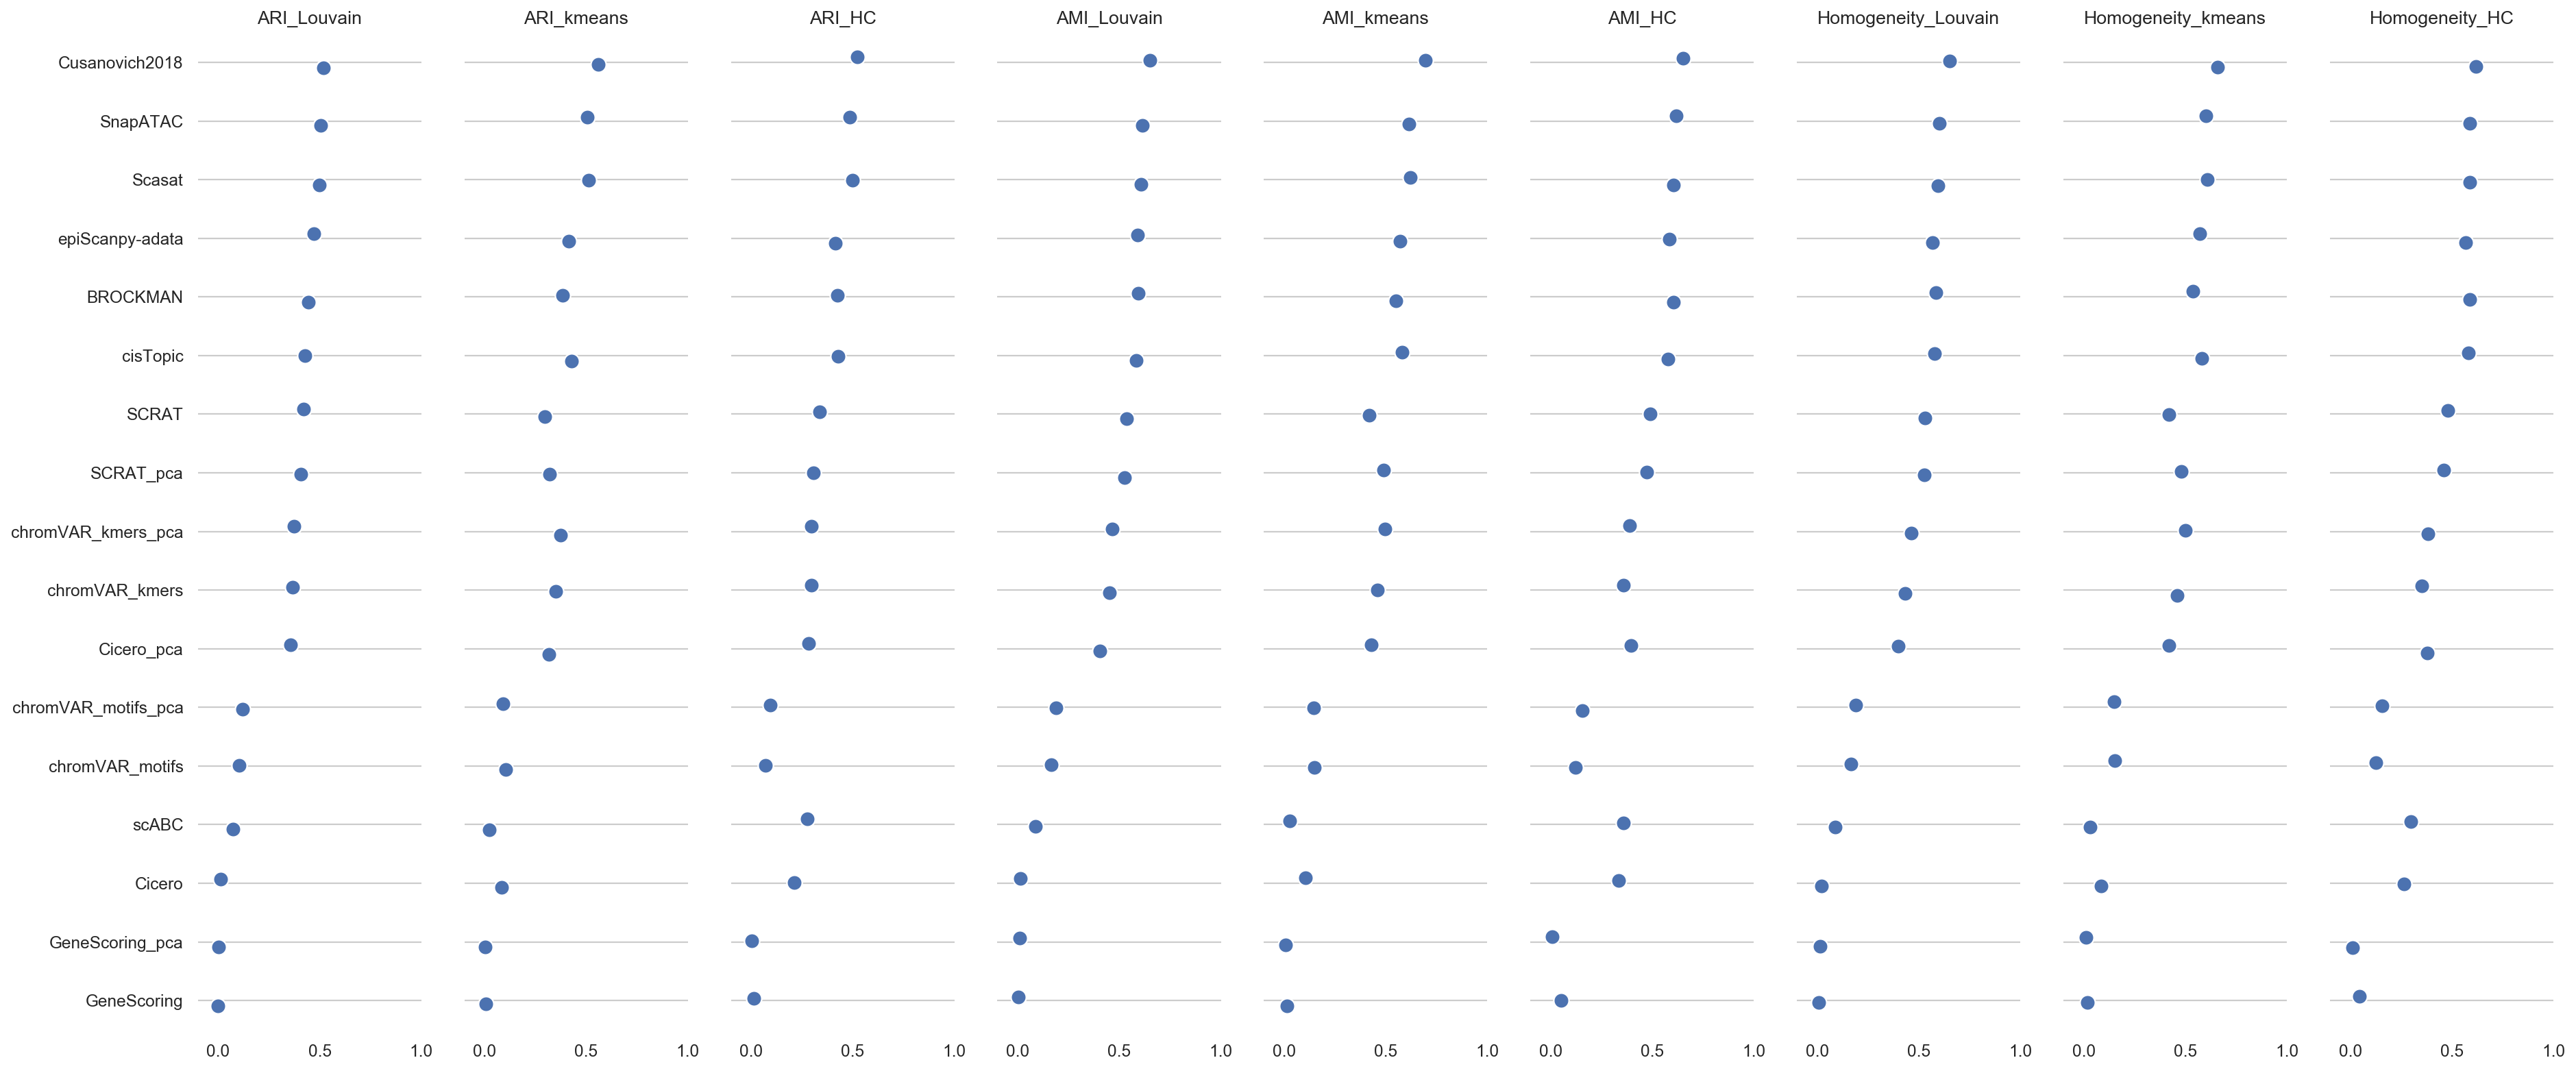

In [23]:
adata = adatareduced.copy()

from sklearn.metrics import adjusted_rand_score

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

############ Benchmarking
all_metrics = """Control	0.497741	0.498302	0.488403	0.612442	0.607714	0.611818	0.592454	0.595279	0.587975
BROCKMAN	0.443817	0.384405	0.425049	0.591878	0.548319	0.603044	0.583846	0.536774	0.588663
Cusanovich2018	0.518985	0.557346	0.520973	0.65191	0.694411	0.651651	0.650078	0.657094	0.617172
cisTopic	0.426681	0.428198	0.427	0.582059	0.578854	0.578283	0.57882	0.580315	0.580238
chromVAR_kmers	0.367749	0.348663	0.297824	0.451998	0.45965	0.35703	0.432026	0.461088	0.352456
chromVAR_motifs	0.101836	0.102986	0.0694161	0.1653	0.14777	0.122929	0.167011	0.152132	0.125115
chromVAR_kmers_pca	0.372098	0.374914	0.294734	0.465553	0.496276	0.387262	0.463427	0.498582	0.381975
chromVAR_motifs_pca	0.121054	0.0905712	0.0930063	0.188937	0.145689	0.155174	0.190978	0.150077	0.156825
GeneScoring	-0.000120752	0.00577751	0.0138995	0.00291468	0.0122876	0.0513902	0.00851104	0.0161987	0.0442105
GeneScoring_pca	0.00358284	0.00187602	0.0017292	0.00941856	0.00729027	0.00784308	0.0137504	0.0116766	0.0120619
Cicero	0.0121098	0.083018	0.212315	0.0147164	0.103785	0.333521	0.0197579	0.0865826	0.26518
Cicero_pca	0.354803	0.316956	0.283117	0.404299	0.426715	0.395462	0.400145	0.417876	0.379171
SnapATAC	0.505748	0.505138	0.485932	0.614573	0.615253	0.616791	0.601021	0.602294	0.589024
Scasat	0.497175	0.513178	0.498159	0.60743	0.620666	0.604752	0.593773	0.607801	0.588698
scABC	0.0733737	0.0219744	0.274395	0.0866164	0.0281832	0.35884	0.0879831	0.0316541	0.297886
SCRAT	0.420341	0.296208	0.337653	0.535693	0.419763	0.488362	0.529769	0.420522	0.47925
SCRAT_pca	0.407336	0.32115	0.304999	0.526936	0.490409	0.470972	0.52637	0.479973	0.461012
"""

    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy-adata'

# convert the cell label to standard label
adata.obs['label'] = adata.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adata.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adata,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = pd.Series(kmeans.labels_,index=adata.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.obsm['X_pca'])
adata.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adata.obs['label'], adata.obs['louvain'])
ari_kmeans = adjusted_rand_score(adata.obs['label'], adata.obs['kmeans'])
ari_hc = adjusted_rand_score(adata.obs['label'], adata.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adata.obs['label'], adata.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adata.obs['label'], adata.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adata.obs['label'], adata.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adata.obs['label'], adata.obs['louvain'])
homo_kmeans = homogeneity_score(adata.obs['label'], adata.obs['kmeans'])
homo_hc = homogeneity_score(adata.obs['label'], adata.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics[1:]:
    print(line)
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_Louvain",
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics